# Import libraries

In [577]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import librosa
import soundfile as sf

import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T

from sklearn.cluster import KMeans

# (Librosa) Load and Process Data

In [552]:
# load the audio with librosa in lower sample rate
wv_librosa_sr, sr_librosa_sr = librosa.load("../../data/Balance Memory.wav")

wv_librosa_sr, wv_librosa_sr.shape, sr_librosa_sr

(array([-0.02099079, -0.02828838, -0.02593338, ..., -0.23950645,
        -0.23623453, -0.24782246], dtype=float32),
 (330750,),
 22050)

In [553]:
# load the audio with librosa in 32khz, the default sample rate
wv_librosa, sr_librosa = librosa.load("../../data/Balance Memory.wav", sr=32000)

wv_librosa, wv_librosa.shape, sr_librosa

(array([-0.02627563, -0.02667236, -0.02664185, ..., -0.23928833,
        -0.23931885, -0.2401123 ], dtype=float32),
 (480000,),
 32000)

In [554]:
# calculate mel spectogram with the sample rate
mel_librosa = librosa.feature.melspectrogram(
    y=wv_librosa,
    sr=sr_librosa,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

mel_librosa, mel_librosa.shape

(array([[7.8394003e-03, 1.3747171e-04, 1.4267817e-04, ..., 3.9486961e+01,
         5.6667221e+01, 1.2345200e+02],
        [1.9790067e-03, 3.5491801e-04, 1.8899546e-04, ..., 4.3814306e+00,
         1.0700668e+01, 2.5751408e+01],
        [5.5085937e-03, 6.3771643e-03, 3.7669364e-02, ..., 5.5715400e-01,
         7.4186420e-01, 1.0564188e+00],
        ...,
        [6.3033635e-06, 3.1591676e-09, 2.4814675e-09, ..., 5.7055920e-09,
         5.2979279e-09, 1.2413082e-04],
        [6.3953303e-06, 2.9834717e-09, 2.8564906e-09, ..., 7.0294139e-09,
         7.5115434e-09, 1.2300805e-04],
        [5.0494136e-06, 1.9746578e-09, 1.7566129e-09, ..., 3.1980629e-09,
         4.6242379e-09, 1.1659229e-04]], dtype=float32),
 (64, 938))

In [555]:
# convert to decibels (normalize)
mel_librosa_log = librosa.amplitude_to_db(mel_librosa)

mel_librosa_log, mel_librosa_log.shape

(array([[-32.48626   , -32.48626   , -32.48626   , ...,  31.929073  ,
          35.06664   ,  41.829964  ],
        [-32.48626   , -32.48626   , -32.48626   , ...,  12.832318  ,
          20.588219  ,  28.216019  ],
        [-32.48626   , -32.48626   , -28.480234  , ...,  -5.080495  ,
          -2.5935113 ,   0.47672242],
        ...,
        [-32.48626   , -32.48626   , -32.48626   , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [-32.48626   , -32.48626   , -32.48626   , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [-32.48626   , -32.48626   , -32.48626   , ..., -32.48626   ,
         -32.48626   , -32.48626   ]], dtype=float32),
 (64, 938))

In [556]:
mel_librosa_log_transpose = mel_librosa_log.T

mel_librosa_log_transpose, mel_librosa_log_transpose.shape

(array([[-32.48626   , -32.48626   , -32.48626   , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [-32.48626   , -32.48626   , -32.48626   , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [-32.48626   , -32.48626   , -28.480234  , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        ...,
        [ 31.929073  ,  12.832318  ,  -5.080495  , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [ 35.06664   ,  20.588219  ,  -2.5935113 , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [ 41.829964  ,  28.216019  ,   0.47672242, ..., -32.48626   ,
         -32.48626   , -32.48626   ]], dtype=float32),
 (938, 64))

In [557]:
# create df
df_librosa = pd.DataFrame(mel_librosa_log_transpose) # transpose for time rows

df_librosa

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-15.892344,-13.493561,-14.590464,-6.068701,-13.325738,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
1,-32.486259,-32.486259,-32.486259,-30.018620,-32.486259,-9.199663,1.046602,1.864609,6.168241,-19.041531,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
2,-32.486259,-32.486259,-28.480234,-10.490613,-19.115448,-8.730347,-2.419414,2.684580,9.246306,-13.079181,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
3,-32.486259,-32.486259,-24.106857,-4.923679,-13.974628,-5.377695,8.241421,4.396136,6.544615,-17.883335,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
4,-32.486259,-32.486259,-23.733116,-4.895738,-14.620181,-6.290042,-0.109114,-2.892497,0.664512,-28.408689,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,31.271580,15.737822,-4.916617,-32.486259,-32.486259,-15.654840,-20.941238,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
934,19.713322,13.835960,-16.410021,-26.573008,-17.096123,-5.929788,-14.075822,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
935,31.929073,12.832318,-5.080495,-25.084759,-27.236526,-21.793566,-18.129677,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
936,35.066639,20.588219,-2.593511,-21.328472,-20.751068,-17.238737,-20.210371,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259


In [558]:
# add time , by defining the time windows in seconds
time = librosa.times_like(mel_librosa, sr=sr_librosa)

time, time.shape

(array([ 0.   ,  0.016,  0.032,  0.048,  0.064,  0.08 ,  0.096,  0.112,
         0.128,  0.144,  0.16 ,  0.176,  0.192,  0.208,  0.224,  0.24 ,
         0.256,  0.272,  0.288,  0.304,  0.32 ,  0.336,  0.352,  0.368,
         0.384,  0.4  ,  0.416,  0.432,  0.448,  0.464,  0.48 ,  0.496,
         0.512,  0.528,  0.544,  0.56 ,  0.576,  0.592,  0.608,  0.624,
         0.64 ,  0.656,  0.672,  0.688,  0.704,  0.72 ,  0.736,  0.752,
         0.768,  0.784,  0.8  ,  0.816,  0.832,  0.848,  0.864,  0.88 ,
         0.896,  0.912,  0.928,  0.944,  0.96 ,  0.976,  0.992,  1.008,
         1.024,  1.04 ,  1.056,  1.072,  1.088,  1.104,  1.12 ,  1.136,
         1.152,  1.168,  1.184,  1.2  ,  1.216,  1.232,  1.248,  1.264,
         1.28 ,  1.296,  1.312,  1.328,  1.344,  1.36 ,  1.376,  1.392,
         1.408,  1.424,  1.44 ,  1.456,  1.472,  1.488,  1.504,  1.52 ,
         1.536,  1.552,  1.568,  1.584,  1.6  ,  1.616,  1.632,  1.648,
         1.664,  1.68 ,  1.696,  1.712,  1.728,  1.744,  1.76 , 

In [559]:
df_librosa.index = time

df_librosa

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0.000,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-15.892344,-13.493561,-14.590464,-6.068701,-13.325738,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
0.016,-32.486259,-32.486259,-32.486259,-30.018620,-32.486259,-9.199663,1.046602,1.864609,6.168241,-19.041531,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
0.032,-32.486259,-32.486259,-28.480234,-10.490613,-19.115448,-8.730347,-2.419414,2.684580,9.246306,-13.079181,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
0.048,-32.486259,-32.486259,-24.106857,-4.923679,-13.974628,-5.377695,8.241421,4.396136,6.544615,-17.883335,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
0.064,-32.486259,-32.486259,-23.733116,-4.895738,-14.620181,-6.290042,-0.109114,-2.892497,0.664512,-28.408689,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.928,31.271580,15.737822,-4.916617,-32.486259,-32.486259,-15.654840,-20.941238,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
14.944,19.713322,13.835960,-16.410021,-26.573008,-17.096123,-5.929788,-14.075822,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
14.960,31.929073,12.832318,-5.080495,-25.084759,-27.236526,-21.793566,-18.129677,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
14.976,35.066639,20.588219,-2.593511,-21.328472,-20.751068,-17.238737,-20.210371,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259


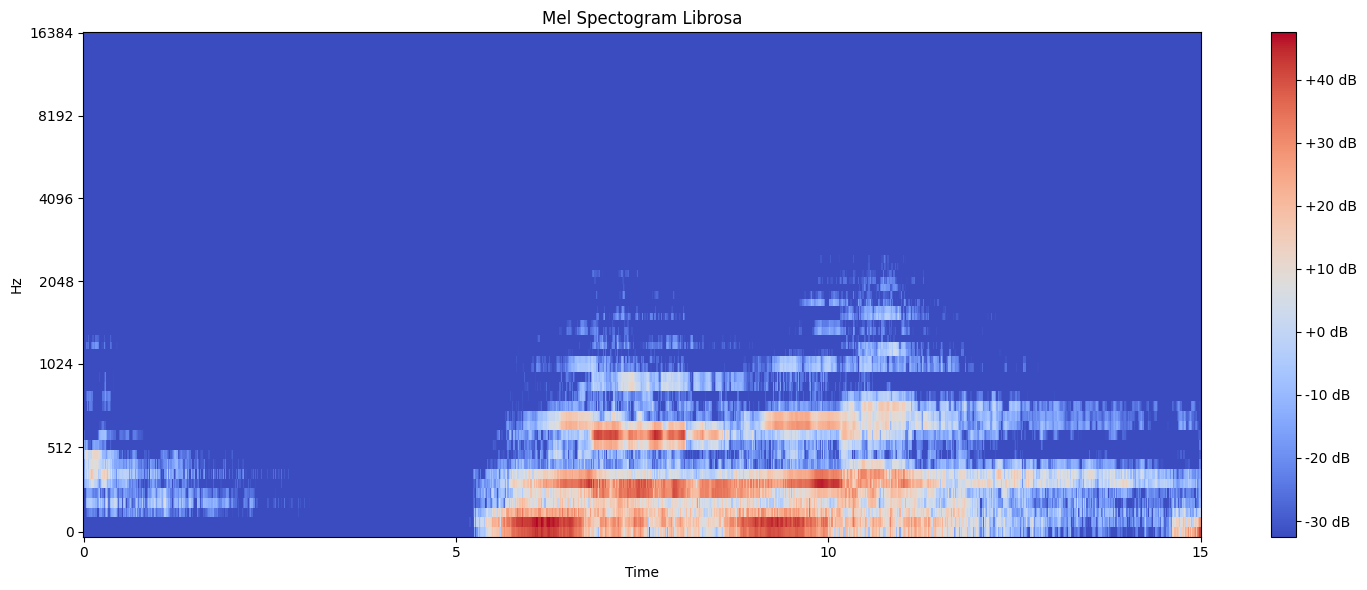

In [560]:
# visualize mel spectogram
plt.figure(figsize=(15, 6))
librosa.display.specshow(mel_librosa_log, sr=sr_librosa, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectogram Librosa")
plt.tight_layout()
plt.show()

# Quantize Preprocess Data

In [561]:
# now we must to convert the data into a neural network compatible representative vectors, or in other words codebook vectors
# we are going to apply the rvq technique, to get a lower and efficient data so called quantize data coming from multiple layers of quantizer below

class ResidualVectorQuantizer(nn.Module):
    def __init__(self, num_codebooks, codebooks_size, features_dim):
        super(ResidualVectorQuantizer, self).__init__()
        self.num_codebooks = num_codebooks
        self.codebooks = nn.Parameter(torch.rand(num_codebooks, codebooks_size, features_dim))
    def initialize_codebooks(self ,x):
        for i in range(self.num_codebooks):
            kmeans = KMeans(n_clusters=self.codebooks.shape[1], random_state=0)
            subset_indices = torch.randperm(x.shape[0])[:min(10000, x.shape[0])]
            subset = x[subset_indices].cpu().numpy()
            kmeans.fit(subset)
            self.codebooks[i].data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
    def quantize(self, x):
        residual = x.clone()
        quantized_output = torch.zeros_like(x)
        quantized_indices = []
        for i in range(self.num_codebooks):
            distances = torch.cdist(residual, self.codebooks[i])
            indices = distances.argmin(dim=1)
            quantized_vectors = self.codebooks[i][indices]
            quantized_output += quantized_vectors
            residual -= quantized_vectors
            quantized_indices.append(indices)
            # print(f"distance shape: {distances.shape}")
            # print(f"indice shape: {indices.shape}")
            # print(f"vector shape: {quantized_vectors.shape}")
        return quantized_output, torch.stack(quantized_indices, dim=1)
    def dequantize(self, quantize_indices):
        reconstructed = torch.zeros((quantize_indices.shape[0], self.codebooks.shape[2])).to(device)
        for i in range(self.num_codebooks):
            reconstructed += self.codebooks[i][quantize_indices[:, i]]
        return reconstructed

# initialize the model, the optimizer and its hyperparameters
device = ("cuda" if torch.cuda.is_available() else "cpu")
num_codebooks = 4
codebook_size = 512
feature_dim = mel_librosa_log_transpose.shape[1]
epochs = 60000
learning_rate = 0.001
rvq = ResidualVectorQuantizer(num_codebooks, codebook_size, feature_dim).to(device)
optim = optim.Adam(rvq.parameters(), lr=learning_rate)

# initializa original data
print("input tensor in cpu device")
input_tensor = torch.tensor(mel_librosa_log_transpose).to(device)
input_tensor, input_tensor.shape

input tensor in cpu device


(tensor([[-32.4863, -32.4863, -32.4863,  ..., -32.4863, -32.4863, -32.4863],
         [-32.4863, -32.4863, -32.4863,  ..., -32.4863, -32.4863, -32.4863],
         [-32.4863, -32.4863, -28.4802,  ..., -32.4863, -32.4863, -32.4863],
         ...,
         [ 31.9291,  12.8323,  -5.0805,  ..., -32.4863, -32.4863, -32.4863],
         [ 35.0666,  20.5882,  -2.5935,  ..., -32.4863, -32.4863, -32.4863],
         [ 41.8300,  28.2160,   0.4767,  ..., -32.4863, -32.4863, -32.4863]],
        device='cuda:0'),
 torch.Size([938, 64]))

In [562]:
# lets initialize the codebook from the rvq
rvq.initialize_codebooks(input_tensor)

In [563]:
# train codebook
best_loss = float("inf")
no_improvement = 0
for i in range(epochs):
    optim.zero_grad()
    quantized_output, _ = rvq.quantize(input_tensor)
    loss = torch.mean((input_tensor - quantized_output)**2)
    loss.backward()
    optim.step()
    torch.save(rvq.state_dict(), "./weights/checkpoint_rvq_model.pth")
    torch.save(optim.state_dict(), "./weights/checkpoint_rvq_optimizer.pth")
    if (i + 1) % 10 == 0:
        print(f"epoch {i}, loss: {loss.item()}") 
    if loss < best_loss:
        best_loss = loss
        no_improvement = 0
        torch.save(rvq.state_dict(), './weights/best_rvq_model.pth')
    else:
        no_improvement
    if no_improvement > 50:
        print("no more improvement")
        break

epoch 9, loss: 1024.247314453125
epoch 19, loss: 1021.8306274414062
epoch 29, loss: 1019.4027709960938
epoch 39, loss: 1016.9501342773438
epoch 49, loss: 1014.4645385742188
epoch 59, loss: 1011.9271240234375
epoch 69, loss: 1009.1895751953125
epoch 79, loss: 1006.06103515625
epoch 89, loss: 1002.4290161132812
epoch 99, loss: 998.5867919921875
epoch 109, loss: 994.6736450195312
epoch 119, loss: 990.8317260742188
epoch 129, loss: 987.1925048828125
epoch 139, loss: 983.7384033203125
epoch 149, loss: 980.4291381835938
epoch 159, loss: 977.2328491210938
epoch 169, loss: 974.1103515625
epoch 179, loss: 971.0272216796875
epoch 189, loss: 967.9637451171875
epoch 199, loss: 964.9258422851562
epoch 209, loss: 961.90234375
epoch 219, loss: 958.8724975585938
epoch 229, loss: 955.84033203125
epoch 239, loss: 952.8130493164062
epoch 249, loss: 949.8011474609375
epoch 259, loss: 946.7322998046875
epoch 269, loss: 943.534423828125
epoch 279, loss: 940.37451171875
epoch 289, loss: 937.2842407226562
epo

In [564]:
# now lets get the quantized values and analyse its shape
quantized_output, quantized_indices = rvq.quantize(input_tensor)

print(f"QUANTIZED OUTPUT and its shape: \n {quantized_output, quantized_output.shape}\n")
print(f"QUANTIZED INDICES and its shape: \n {quantized_indices, quantized_indices.shape}\n")

QUANTIZED OUTPUT and its shape: 
 (tensor([[-32.3648, -32.2403, -21.6411,  ..., -32.4865, -32.4862, -32.4860],
        [-32.3648, -32.2403, -21.6411,  ..., -32.4865, -32.4862, -32.4860],
        [-32.3648, -32.2403, -21.6411,  ..., -32.4865, -32.4862, -32.4860],
        ...,
        [ 16.0572,  14.3625,  -0.3046,  ..., -32.4865, -32.4862, -32.4860],
        [ 16.0572,  14.3625,  -0.3046,  ..., -32.4865, -32.4862, -32.4860],
        [ 16.0572,  14.3625,  -0.3046,  ..., -32.4865, -32.4862, -32.4860]],
       device='cuda:0', grad_fn=<AddBackward0>), torch.Size([938, 64]))

QUANTIZED INDICES and its shape: 
 (tensor([[111,  97, 368, 168],
        [111,  97, 368, 168],
        [111,  97, 368, 168],
        ...,
        [111,  97, 368, 276],
        [111,  97, 368, 276],
        [111,  97, 368, 276]], device='cuda:0'), torch.Size([938, 4]))



In [565]:
print("checking model output device, in order the make the correct dequantization with gpu")
quantized_indices.device

checking model output device, in order the make the correct dequantization with gpu


device(type='cuda', index=0)

In [566]:
# dequantized the values back into input features data structure
quantized_indices.to(device)

print("quantized indices tenor in the gpu device")
print(quantized_indices.device)

quantized_input_tensor = rvq.dequantize(quantized_indices)
quantized_input_tensor2 = quantized_input_tensor.to("cpu").detach().numpy()

print("quantized input data in cpu device")
quantized_input_tensor2, quantized_input_tensor2.shape

quantized indices tenor in the gpu device
cuda:0
quantized input data in cpu device


(array([[-32.364796  , -32.240295  , -21.64105   , ..., -32.486454  ,
         -32.48624   , -32.486027  ],
        [-32.364796  , -32.240295  , -21.64105   , ..., -32.486454  ,
         -32.48624   , -32.486027  ],
        [-32.364796  , -32.240295  , -21.64105   , ..., -32.486454  ,
         -32.48624   , -32.486027  ],
        ...,
        [ 16.057186  ,  14.362462  ,  -0.30456424, ..., -32.48645   ,
         -32.486244  , -32.486034  ],
        [ 16.057186  ,  14.362462  ,  -0.30456424, ..., -32.48645   ,
         -32.486244  , -32.486034  ],
        [ 16.057186  ,  14.362462  ,  -0.30456424, ..., -32.48645   ,
         -32.486244  , -32.486034  ]], dtype=float32),
 (938, 64))

In [567]:
# now lets compare to the original input features data before quantized state

input_tensor2 = input_tensor.to("cpu").detach().numpy()
input_tensor2, input_tensor2.shape

(array([[-32.48626   , -32.48626   , -32.48626   , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [-32.48626   , -32.48626   , -32.48626   , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [-32.48626   , -32.48626   , -28.480234  , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        ...,
        [ 31.929073  ,  12.832318  ,  -5.080495  , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [ 35.06664   ,  20.588219  ,  -2.5935113 , ..., -32.48626   ,
         -32.48626   , -32.48626   ],
        [ 41.829964  ,  28.216019  ,   0.47672242, ..., -32.48626   ,
         -32.48626   , -32.48626   ]], dtype=float32),
 (938, 64))

In [568]:
# lets view it into dataframe
quantized_df = pd.DataFrame(quantized_input_tensor2)

quantized_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-32.364796,-32.240295,-21.641050,-10.883047,-18.301863,-14.017907,-6.429659,-11.922895,-17.174185,-29.276371,...,-32.486126,-32.486233,-32.486305,-32.486141,-32.486221,-32.486275,-32.486336,-32.486454,-32.486240,-32.486027
1,-32.364796,-32.240295,-21.641050,-10.883047,-18.301863,-14.017907,-6.429659,-11.922895,-17.174185,-29.276371,...,-32.486126,-32.486233,-32.486305,-32.486141,-32.486221,-32.486275,-32.486336,-32.486454,-32.486240,-32.486027
2,-32.364796,-32.240295,-21.641050,-10.883047,-18.301863,-14.017907,-6.429659,-11.922895,-17.174185,-29.276371,...,-32.486126,-32.486233,-32.486305,-32.486141,-32.486221,-32.486275,-32.486336,-32.486454,-32.486240,-32.486027
3,-32.364796,-32.240295,-21.641050,-10.883047,-18.301863,-14.017907,-6.429659,-11.922895,-17.174185,-29.276371,...,-32.486126,-32.486233,-32.486305,-32.486141,-32.486221,-32.486275,-32.486336,-32.486454,-32.486240,-32.486027
4,-32.364796,-32.240295,-21.641050,-10.883047,-18.301863,-14.017907,-6.429659,-11.922895,-17.174185,-29.276371,...,-32.486126,-32.486233,-32.486305,-32.486141,-32.486221,-32.486275,-32.486336,-32.486454,-32.486240,-32.486027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,16.057186,14.362462,-0.304564,-16.406227,-18.417095,-12.140363,-17.102404,-29.232897,-31.679722,-31.961746,...,-32.486122,-32.486237,-32.486301,-32.486141,-32.486225,-32.486267,-32.486336,-32.486450,-32.486244,-32.486034
934,16.057186,14.362462,-0.304564,-16.406227,-18.417095,-12.140363,-17.102404,-29.232897,-31.679722,-31.961746,...,-32.486122,-32.486237,-32.486301,-32.486141,-32.486225,-32.486267,-32.486336,-32.486450,-32.486244,-32.486034
935,16.057186,14.362462,-0.304564,-16.406227,-18.417095,-12.140363,-17.102404,-29.232897,-31.679722,-31.961746,...,-32.486122,-32.486237,-32.486301,-32.486141,-32.486225,-32.486267,-32.486336,-32.486450,-32.486244,-32.486034
936,16.057186,14.362462,-0.304564,-16.406227,-18.417095,-12.140363,-17.102404,-29.232897,-31.679722,-31.961746,...,-32.486122,-32.486237,-32.486301,-32.486141,-32.486225,-32.486267,-32.486336,-32.486450,-32.486244,-32.486034


In [569]:
original_df = pd.DataFrame(input_tensor2)

original_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-15.892344,-13.493561,-14.590464,-6.068701,-13.325738,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
1,-32.486259,-32.486259,-32.486259,-30.018620,-32.486259,-9.199663,1.046602,1.864609,6.168241,-19.041531,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
2,-32.486259,-32.486259,-28.480234,-10.490613,-19.115448,-8.730347,-2.419414,2.684580,9.246306,-13.079181,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
3,-32.486259,-32.486259,-24.106857,-4.923679,-13.974628,-5.377695,8.241421,4.396136,6.544615,-17.883335,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
4,-32.486259,-32.486259,-23.733116,-4.895738,-14.620181,-6.290042,-0.109114,-2.892497,0.664512,-28.408689,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,31.271580,15.737822,-4.916617,-32.486259,-32.486259,-15.654840,-20.941238,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
934,19.713322,13.835960,-16.410021,-26.573008,-17.096123,-5.929788,-14.075822,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
935,31.929073,12.832318,-5.080495,-25.084759,-27.236526,-21.793566,-18.129677,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259
936,35.066639,20.588219,-2.593511,-21.328472,-20.751068,-17.238737,-20.210371,-32.486259,-32.486259,-32.486259,...,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259,-32.486259


In [570]:
# convert data to start plotting out the differences between data in spectogram
original_spectogram_data = librosa.amplitude_to_db(input_tensor2)
quantized_spectogram_data = librosa.amplitude_to_db(quantized_input_tensor2)

original_spectogram_data.shape, quantized_spectogram_data.shape

((938, 64), (938, 64))

In [571]:
# transpose the data to input into spectogram format
original_spectogram_data = original_spectogram_data.T
quantized_spectogram_data = quantized_spectogram_data.T

original_spectogram_data.shape, quantized_spectogram_data.shape

((64, 938), (64, 938))

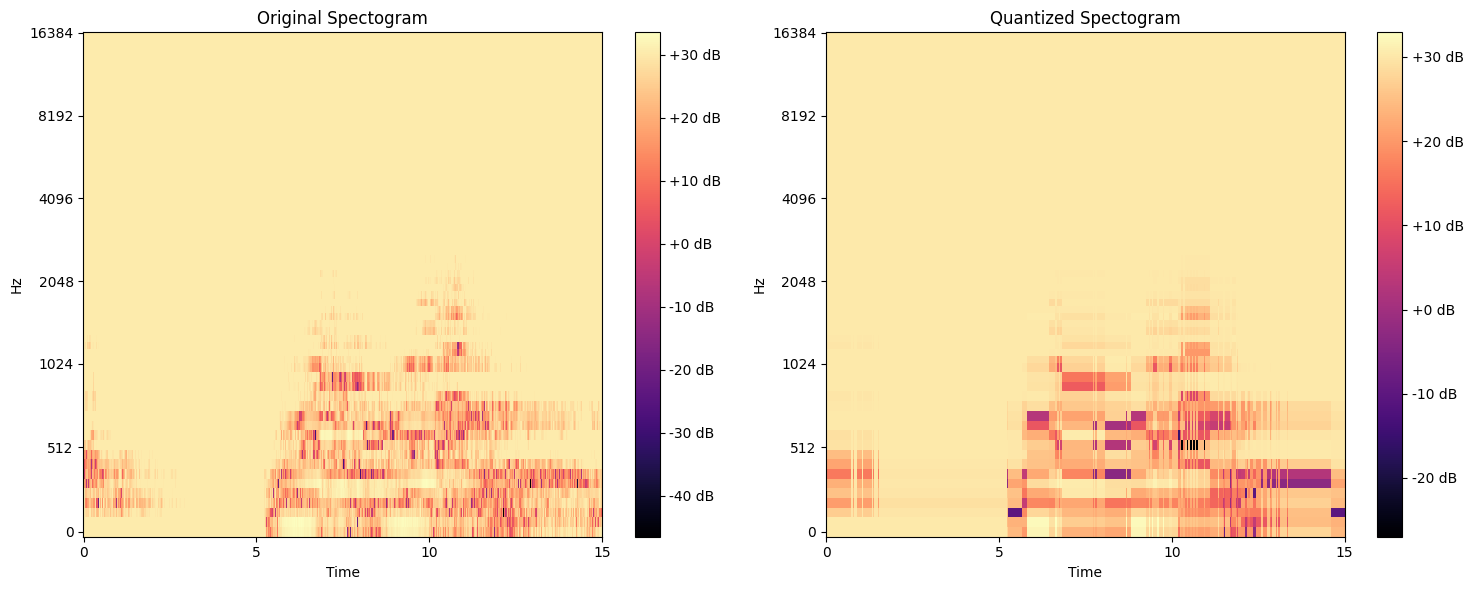

In [572]:
# now lets plot out the original data and quantized in a two differenct spectogram graph
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

img1 = librosa.display.specshow(original_spectogram_data, sr=sr_librosa, x_axis="time", y_axis="mel", ax=axes[0])
axes[0].set_title("Original Spectogram")
fig.colorbar(img1, ax=axes[0], format="%+2.0f dB")

img2 = librosa.display.specshow(quantized_spectogram_data, sr=sr_librosa, x_axis="time", y_axis="mel", ax=axes[1])
axes[1].set_title("Quantized Spectogram")
fig.colorbar(img2, ax=axes[1], format="%+2.0f dB")

# axes[0].label_outer()
# axes[1].label_outer()

plt.tight_layout()
plt.show()

# Convert spectogram data back to waveform and save it

In [575]:
# convert scale back
original_spectogram_inv = librosa.feature.inverse.mel_to_stft(original_spectogram_data, sr=sr_librosa, n_fft=1024)
quantized_spectogram_inv = librosa.feature.inverse.mel_to_stft(quantized_spectogram_data, sr=sr_librosa, n_fft=1024)

original_spectogram_inv.shape, quantized_spectogram_inv.shape

((513, 938), (513, 938))

In [579]:
# griffin-lim algorithm to convert time into audio domain
original_griffinlim = librosa.griffinlim(original_spectogram_inv)
quantized_griffinlim = librosa.griffinlim(quantized_spectogram_inv)

original_griffinlim.shape, quantized_griffinlim.shape

((239872,), (239872,))

In [580]:
# save it in wav form
sf.write("original_audio.wav", original_griffinlim, sr_librosa)
sf.write("quantized_audio.wav", quantized_griffinlim, sr_librosa)